In [1]:
import numpy as np
from glob import glob
import os

from matplotlib import pyplot as plt
from cycler import cycler
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize
plt.style.use('thesis')

from scipy.optimize import curve_fit
import scipy.signal as sig

plt.rcParams.update({'figure.dpi': 150})
plt.rcParams.update({'axes.prop_cycle': cycler(color=['#5994cd', '#d74164', '#4eaa76', '#d88300', '#7365cf', \
                                                      '#c85e3e', '#83a23e', '#c851b1', '#1850a1'])})

from importlib import reload
import data_processing as dp

### Look through the drive/data directory and print folder structure

In [2]:
data_path = '/Users/clarke/Documents/Research/Nanospheres/Data/'
# base_path = '/Volumes/LaCie/gas_collisions/pulse_calibration/sphere_20250908/'
base_path = '/Users/clarke/Data/gas_collisions/pulse_calibration/sphere_20251129/' #sphere_20250908/'
# drive_path = '/Volumes/LaCie/'
drive_path = '/Users/clarke/Data/'
# base_path = '/Volumes/LaCie/pulse_calibration/sphere_20250406/'

if not os.path.exists(drive_path):
    print('Error: check that the external drive is plugged in!')

folders = glob(base_path + '*')

datasets = {}

for folder in folders:
    print(folder.split(base_path)[-1])
    all_items = glob(folder + '/*')
    subfolders = np.unique(['_'.join(s.split('_')[:-1]) for s in all_items])
    sub_datasets = []
    for subfolder in subfolders:
        sub_datasets.append(subfolder.split(base_path)[-1].split('/')[-1])
        print('\t' + subfolder.split(base_path)[-1].split('/')[-1])
    datasets[folder.split(base_path)[-1]] = sub_datasets

20251201_p8e_7e-8mbar_d137khz_0
	20251201_dfg_p8e_200ns_10v
	20251201_dfg_p8e_200ns_12.5v
	20251201_dfg_p8e_200ns_15v
	20251201_dfg_p8e_200ns_17.5v
	20251201_dfg_p8e_200ns_2.5v
	20251201_dfg_p8e_200ns_20v
	20251201_dfg_p8e_200ns_5v
	20251201_dfg_p8e_200ns_7.5v
20251201_electric_calibration_7e-8mbar_0
	20250911_d_p8e_117khz_4vpp_lensholder1
	20251201_d_p8e_117khz_0_5vpp_lensholder1
	20251201_d_p8e_117khz_1vpp_lensholder1
	20251201_d_p8e_117khz_2vpp_lensholder1
	20251201_d_p8e_117khz_3vpp_lensholder1
	20251201_d_p8e_117khz_4vpp_lensholder1
	20251201_d_p8e_117khz_5vpp_lensholder1
	20251201_d_p8e_nodrive
20251201_p8e_7e-8mbar_d137khz_1
	20251201_dfg_p8e_200ns_10v
	20251201_dfg_p8e_200ns_12.5v
	20251201_dfg_p8e_200ns_15v
	20251201_dfg_p8e_200ns_17.5v
	20251201_dfg_p8e_200ns_2.5v
	20251201_dfg_p8e_200ns_20v
	20251201_dfg_p8e_200ns_5v
	20251201_dfg_p8e_200ns_7.5v


### Specify impulse and analysis parameters

In [3]:
pulse_amps_1e = np.asarray([12, 34, 57, 80, 103, 127, 150, 174]) # impulses applied to the particle in eV/c
pulse_amps_V = np.arange(2.5, 21, 2.5) # pulse amplitudes applied to lens holder 1 in V

t_window = 1e-3 # half the window length in ms
f_cutoff_high = 1e5 # upper cutoff frequency for the bandpass filter
f_cutoff_low = 2.5e4 # lower cutoff frequency for the bandpass filter
f_cutoff = [f_cutoff_low, f_cutoff_high]

### Load and process the data

In [104]:
reload(dp)

# choose which dataset to look at
dataset_ind = 0
dataset = list(datasets.keys())[dataset_ind]

# get the list of impulse amplitudes in that dataset
amp_list = np.argsort([float(d.split('v')[0].split('_')[-1]) for d in datasets[dataset]])
amp_list = np.concat(([amp_list[0]], amp_list))

pulse_amps_keV = []
impulses = []
resonance_params = []
suscs = []
pulses = []

# number of files to look at for each amplitude
max_files = 2

# when plotting, only look at one file
plot = False
if plot:
    max_files = 1

# loop through all four files in that dataset in the correct order
for i, file_ind in enumerate(amp_list):
    if i == 0 and plot:
        continue
    filename = datasets[list(datasets.keys())[dataset_ind]][file_ind]
    plot_path = 'figures/' + base_path.split(drive_path)[-1] + dataset + '/' + filename \
                if plot else None
    nd = dp.NanoDataset(base_path + dataset + '/' + filename, plot_path, \
                        t_window=t_window, f_cutoff=f_cutoff, verbose=True, max_files=max_files)
    nd.load_files(global_params=True, pulse_amps_1e=pulse_amps_1e, pulse_amps_V=pulse_amps_V, noise=i==0, search=True)
    impulses.append(nd.forces.copy())
    pulse_amps_keV.append([nd.pulse_amp_keV.copy(), 0][i==0])
    resonance_params.append(nd.resonance_params.copy())
    suscs.append(nd.suscs.copy())
    pulses.append(nd.pulses.copy())
    freqs = nd.freqs

    del nd

min_len = np.amin([len(l) for l in impulses])
impulses = np.array([l[:min_len] for l in impulses])
suscs = np.array([l[:min_len] for l in suscs])
pulses = np.array([l[:min_len] for l in pulses])
resonance_params = np.array([l[:min_len] for l in resonance_params])

Loading file 1...
    -> Computing force for impulse at t=0.17609 seconds...
    -> Computing force for impulse at t=0.47608 seconds...
    -> Computing force for impulse at t=0.77608 seconds...
    -> Computing force for impulse at t=1.07607 seconds...
    -> Computing force for impulse at t=1.37607 seconds...
    -> Computing force for impulse at t=1.67607 seconds...
    -> Computing force for impulse at t=1.97606 seconds...
    -> Computing force for impulse at t=2.27606 seconds...
    -> Computing force for impulse at t=2.57605 seconds...
    -> Computing force for impulse at t=2.87605 seconds...
    -> Computing force for impulse at t=3.17605 seconds...
    -> Computing force for impulse at t=3.47604 seconds...
    -> Computing force for impulse at t=3.77604 seconds...
    -> Computing force for impulse at t=4.07603 seconds...
    -> Computing force for impulse at t=4.37603 seconds...
    -> Computing force for impulse at t=4.67603 seconds...
    -> Computing force for impulse at 

### Monitor drifts in the resonance over time

Text(0.5, 0.98, 'Resonance parameter drift')

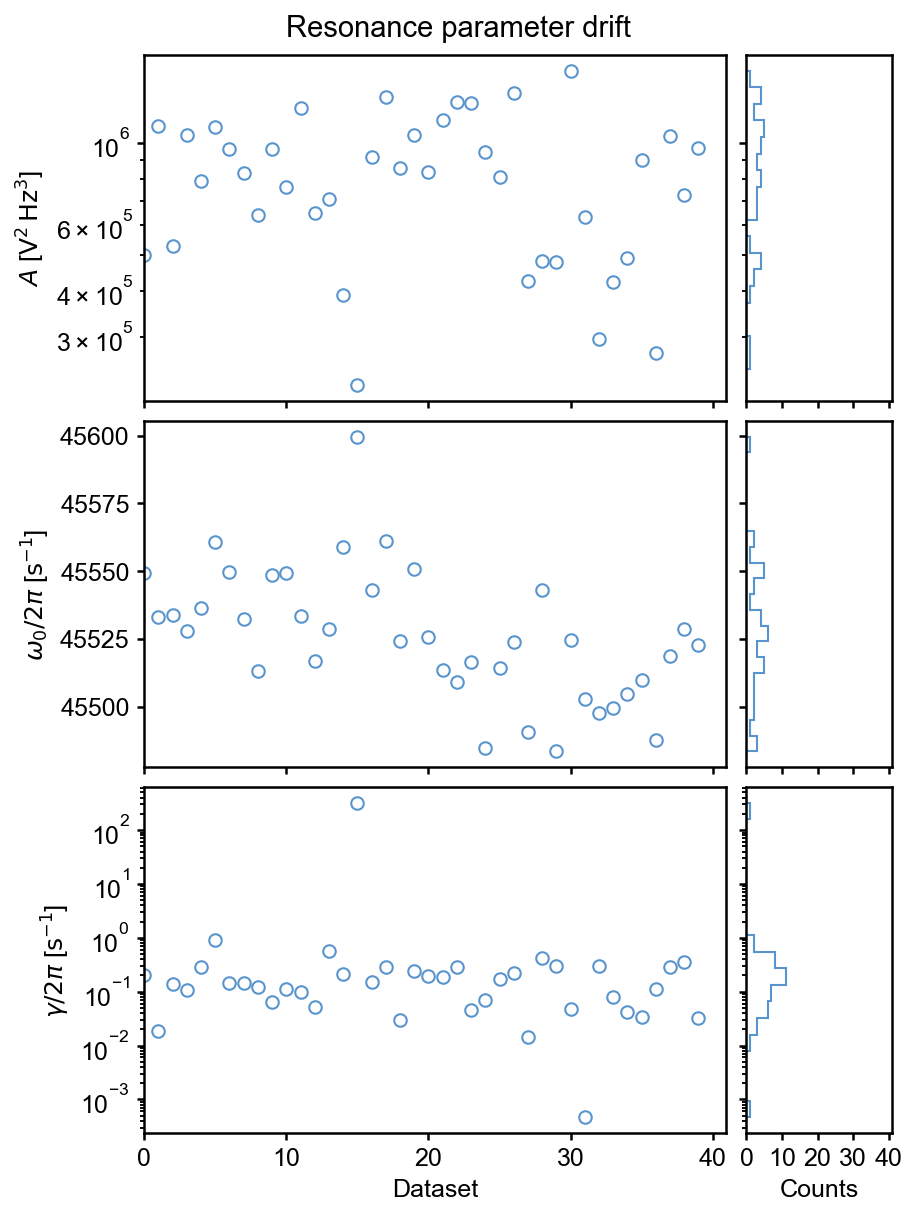

In [105]:
fig, ax = plt.subplots(3, 2, figsize=(6, 8), sharex=True, sharey='row', width_ratios=[4, 1], layout='constrained')
ax[0,0].semilogy(resonance_params[0,:,0], marker='o', ls='none', fillstyle='none')
ax[0,1].hist(resonance_params[0,:,0], bins=np.logspace(np.log10(np.amin(resonance_params[0,:,0])), \
             np.log10(np.amax(resonance_params[0,:,0])), 20), histtype='step', orientation='horizontal')
ax[1,0].plot(resonance_params[0,:,1]/2/np.pi, marker='o', ls='none', fillstyle='none')
ax[1,1].hist(resonance_params[0,:,1]/2/np.pi, bins=20, histtype='step', orientation='horizontal')
ax[2,0].semilogy(resonance_params[0,:,2]/2/np.pi, marker='o', ls='none', fillstyle='none')
ax[2,1].hist(resonance_params[0,:,2]/2/np.pi, bins=np.logspace(np.log10(np.amin(resonance_params[0,:,2]/2/np.pi)), \
             np.log10(np.amax(resonance_params[0,:,2]/2/np.pi)), 20), \
             histtype='step', orientation='horizontal')
ax[0,0].set_ylabel(r'$A$ [$\mathrm{V^2\,Hz^3}$]')
ax[1,0].set_ylabel(r'$\omega_0/2\pi$ [$\mathrm{s}^{-1}$]')
ax[2,0].set_ylabel(r'$\gamma/2\pi$ [$\mathrm{s}^{-1}$]')
ax[2,0].set_xlabel('Dataset')
ax[2,1].set_xlabel('Counts')
fig.suptitle('Resonance parameter drift')

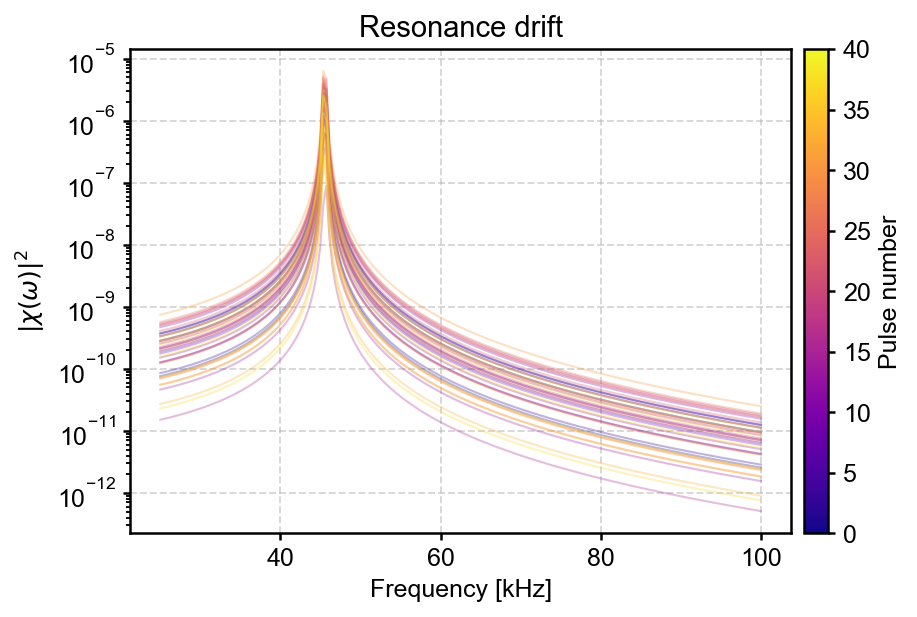

In [106]:
fig, ax = plt.subplots(figsize=(6, 4), layout='constrained')

omegas = 2*np.pi*np.linspace(f_cutoff_low, f_cutoff_high, 200)
colors = [plt.get_cmap('plasma', resonance_params.shape[1])(i) for i in range(resonance_params.shape[1])]

for i, params in enumerate(resonance_params[0, :]):
    ax.plot(1e-3*omegas/2/np.pi, dp.abs_susc2(omegas, *params), alpha=0.3, color=colors[i])

ax.set_yscale('log')
ax.set_xlabel('Frequency [kHz]')
ax.set_ylabel(r'$|\chi(\omega)|^2$')
ax.set_title('Resonance drift')
ax.grid()
fig.colorbar(ScalarMappable(norm=Normalize(0, resonance_params.shape[1]), cmap='plasma'), ax=ax, label='Pulse number', pad=0.02)

### Look at the average waveform for each impulse magnitude

Text(0.5, 0.98, 'Average waveforms')

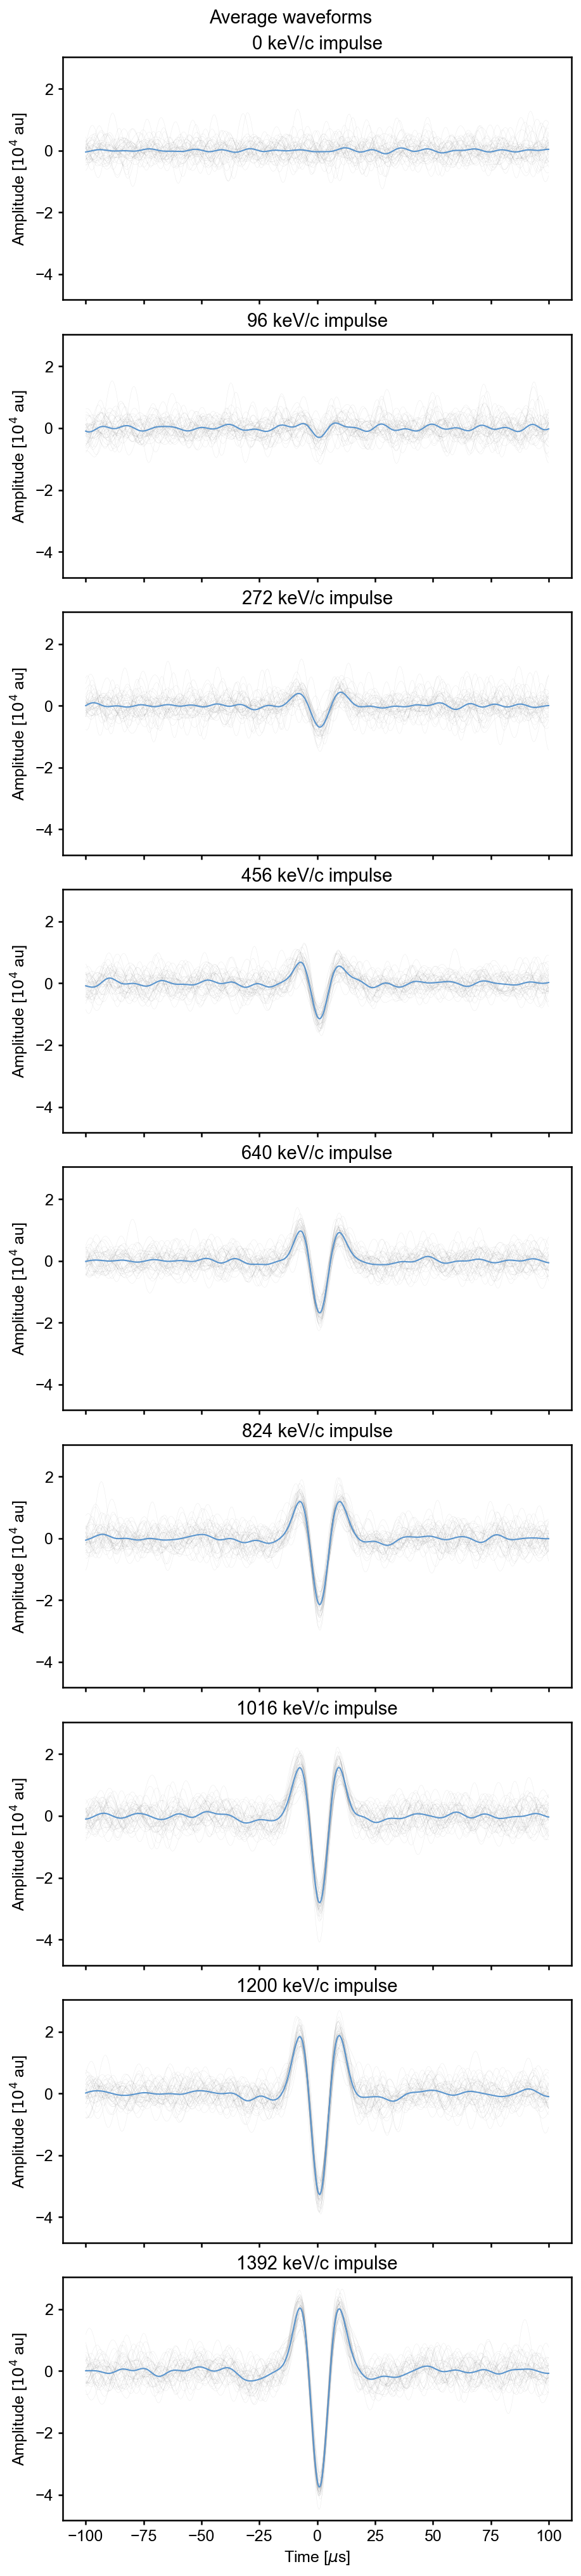

In [107]:
mean_pulses = np.mean(pulses, axis=1)
times = np.arange(0, mean_pulses.shape[-1]/2./freqs[-1], 1./2./freqs[-1])
times -= np.mean(times)

fig, ax = plt.subplots(mean_pulses.shape[0], figsize=(6, 3*mean_pulses.shape[0]), \
                       sharex=True, sharey=True, layout='constrained')
for i in range(mean_pulses.shape[0]):
    ax[i].plot(times*1e6, pulses[i].T*1e-4, lw=0.2, alpha=0.1, color='k')
    ax[i].plot(times*1e6, mean_pulses[i]*1e-4)
    ax[i].set_ylabel('Amplitude [$10^4$ au]')
    ax[i].set_title('{:.0f} keV/c impulse'.format(pulse_amps_keV[i]))
ax[-1].set_xlabel(r'Time [$\mu$s]')
fig.suptitle('Average waveforms')

### Calibrate to the known impulses

0 keV/c impulse:		 61.5 keV resolution
96 keV/c impulse:		 64.3 keV resolution
272 keV/c impulse:	 82.3 keV resolution
456 keV/c impulse:	 106.2 keV resolution
640 keV/c impulse:	 92.6 keV resolution
824 keV/c impulse:	 123.1 keV resolution
1016 keV/c impulse:	 131.8 keV resolution
1200 keV/c impulse:	 124.6 keV resolution
1392 keV/c impulse:	 83.6 keV resolution


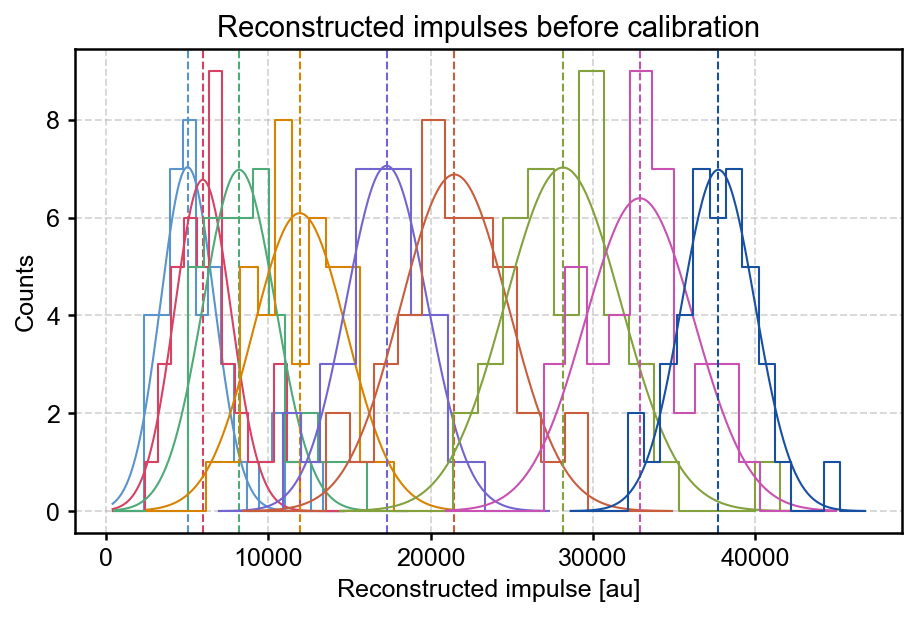

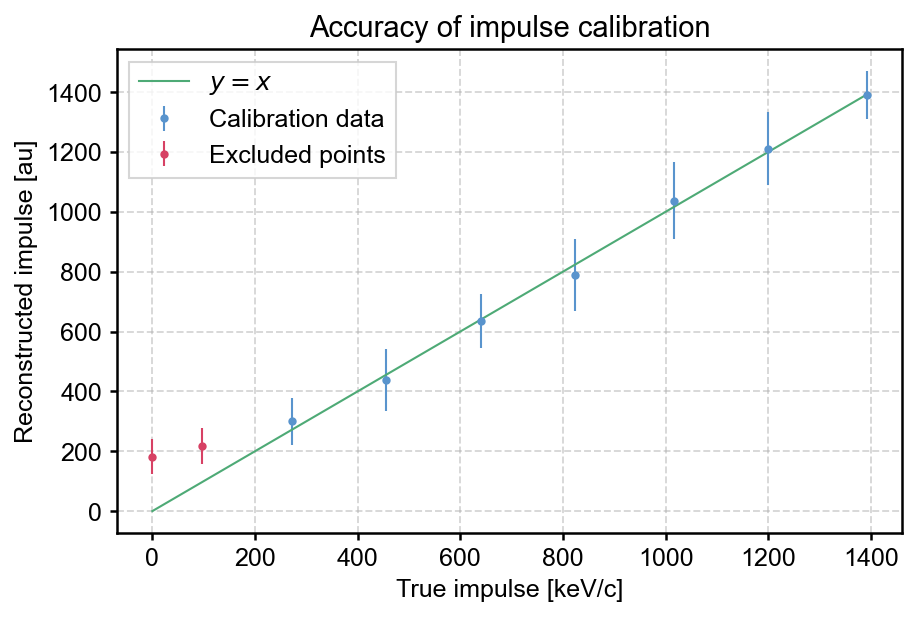

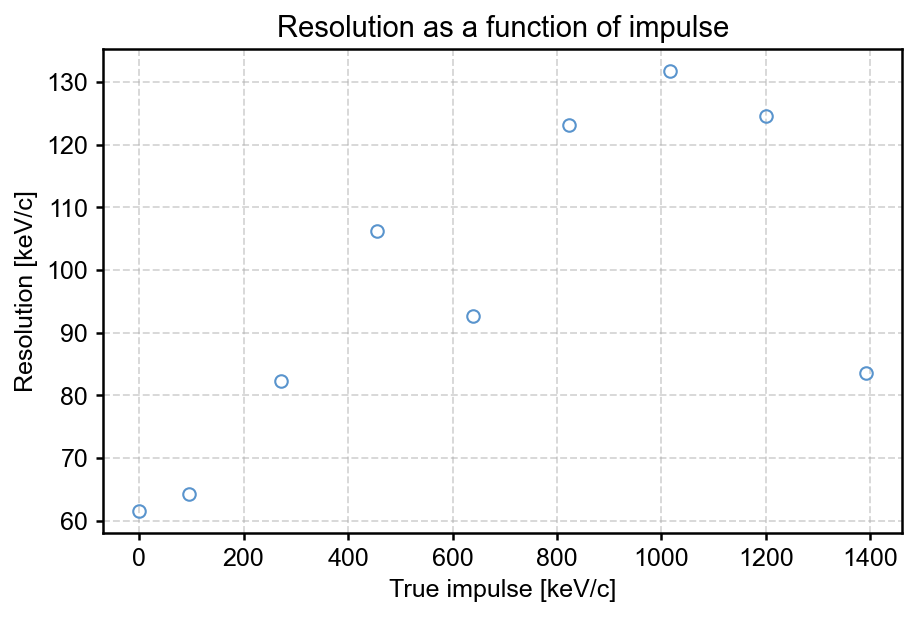

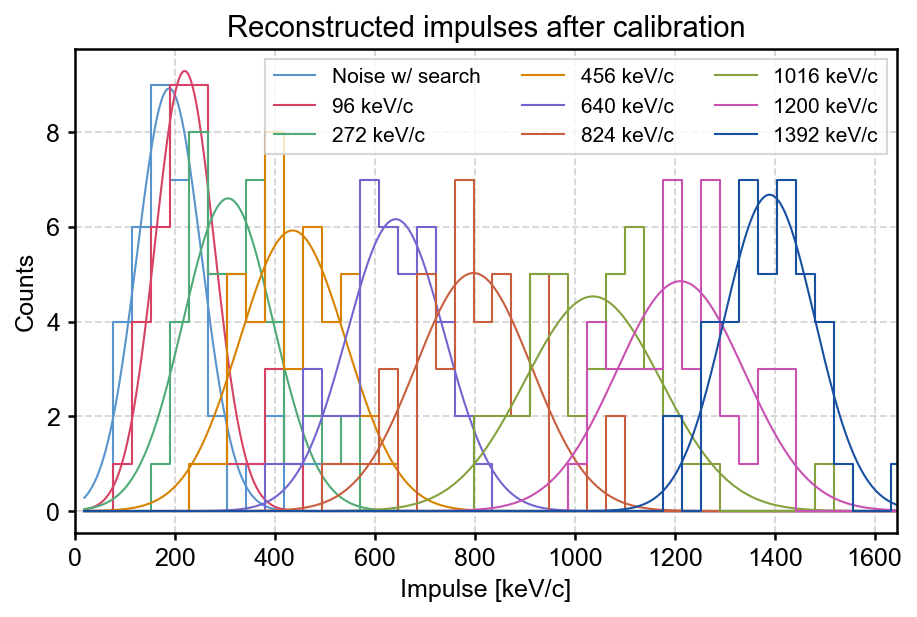

In [108]:
def gaus(x, A, mu, sigma):
    return A*np.exp(-(x - mu)**2/2/sigma**2)

def linear(x, m, b):
    return m*x + b

def to_keV(x, m, b):
    return (x - b)/m

means = []
errs = []

fig, ax = plt.subplots(figsize=(6, 4), layout='constrained')
for i, imp in enumerate(impulses):
    mean = np.mean(np.abs(imp))
    std = np.std(np.abs(imp))
    counts, bins = np.histogram(np.abs(imp), bins=np.linspace(np.amax((0, mean - 4*std)), mean + 4*std, 20))
    bins = (bins[:-1] + bins[1:])/2.
    p, _ = curve_fit(gaus, bins, counts, p0=(10, np.mean(np.abs(imp)), np.std(np.abs(imp))))
    plot_bins = np.linspace(bins[0], bins[-1], 200)
    ax.step(bins, counts, color='C' + str(i), where='mid')
    ax.plot(plot_bins, gaus(plot_bins, *p), color='C' + str(i))
    means.append(p[1])
    errs.append(np.abs(p[2]))
    ax.axvline(p[1], ls='--', color='C' + str(i))
ax.set_xlabel('Reconstructed impulse [au]')
ax.set_ylabel('Counts')
# ax.set_xlim([0, 250])
ax.set_title('Reconstructed impulses before calibration')
ax.grid()

means = np.array(means)
errs = np.array(errs)

exclude_first = 2 # how many of the first datasets to exclude from the calibration line fit

fig, ax = plt.subplots(figsize=(6, 4), layout='constrained')
plot_amps = np.linspace(0, np.amax(pulse_amps_keV), 2)
cal_params, _ = curve_fit(linear, pulse_amps_keV[exclude_first:], means[exclude_first:])
ax.errorbar(pulse_amps_keV[exclude_first:], to_keV(means[exclude_first:], *cal_params), \
            to_keV(errs[exclude_first:], *cal_params), marker='.', ls='none', label='Calibration data')
ax.errorbar(pulse_amps_keV[:exclude_first], to_keV(means[:exclude_first], *cal_params), \
            to_keV(errs[:exclude_first], *cal_params), marker='.', ls='none', label='Excluded points')
ax.plot(plot_amps, plot_amps, label='$y=x$')
# ax.text(0.95, 0.05, '${}x+{}$'.format(*cal_params), ha='right', va='bottom', transform=ax.transAxes)
ax.set_xlabel('True impulse [keV/c]')
ax.set_ylabel('Reconstructed impulse [au]')
ax.set_title('Accuracy of impulse calibration')
ax.legend()
ax.grid()

fig, ax = plt.subplots(figsize=(6, 4), layout='constrained')
ax.plot(pulse_amps_keV, to_keV(errs, cal_params[0], 0), marker='o', ls='none', fillstyle='none')
ax.set_xlabel('True impulse [keV/c]')
ax.set_ylabel('Resolution [keV/c]')
ax.set_title('Resolution as a function of impulse')
ax.grid()

fig, ax = plt.subplots(figsize=(6, 4), layout='constrained')
for i, imp in enumerate(impulses):
    if i == 0:
        label = 'Noise w/ search'
    else:
        label = '{:.0f} keV/c'.format(pulse_amps_keV[i])
    imp_cal = np.abs(imp)/cal_params[0] - cal_params[1]/cal_params[0]
    counts, bins = np.histogram(imp_cal, bins=np.linspace(0, 3000, 80))
    bins = (bins[:-1] + bins[1:])/2.
    p0 = (100, np.mean(imp_cal), np.std(imp_cal))
    try:
        p, _ = curve_fit(gaus, bins, counts, p0=p0)
    except RuntimeError:
        p = p0
    plot_bins = np.linspace(bins[0], bins[-1], 1000)
    ax.step(bins, counts, color='C' + str(i), where='mid')
    ax.plot(plot_bins, gaus(plot_bins, *p), color='C' + str(i), label=label)
ax.set_xlim([0, means[-1]/cal_params[0] + 3*errs[-1]/cal_params[0]])
ax.set_xlabel('Impulse [keV/c]')
ax.set_ylabel('Counts')
ax.grid()
ax.legend(ncol=len(impulses)//3, fontsize=10)
ax.set_title('Reconstructed impulses after calibration')

resolutions = errs/cal_params[0]
for pulse, res in zip(pulse_amps_keV, resolutions):
    print('{:.0f} keV/c impulse:{} {:.1f} keV resolution'.format(pulse, '\t'*(1 + int(np.log10(pulse + 1e-12) < 2)), res))

Text(0.5, 0.98, 'Average waveforms after calibration')

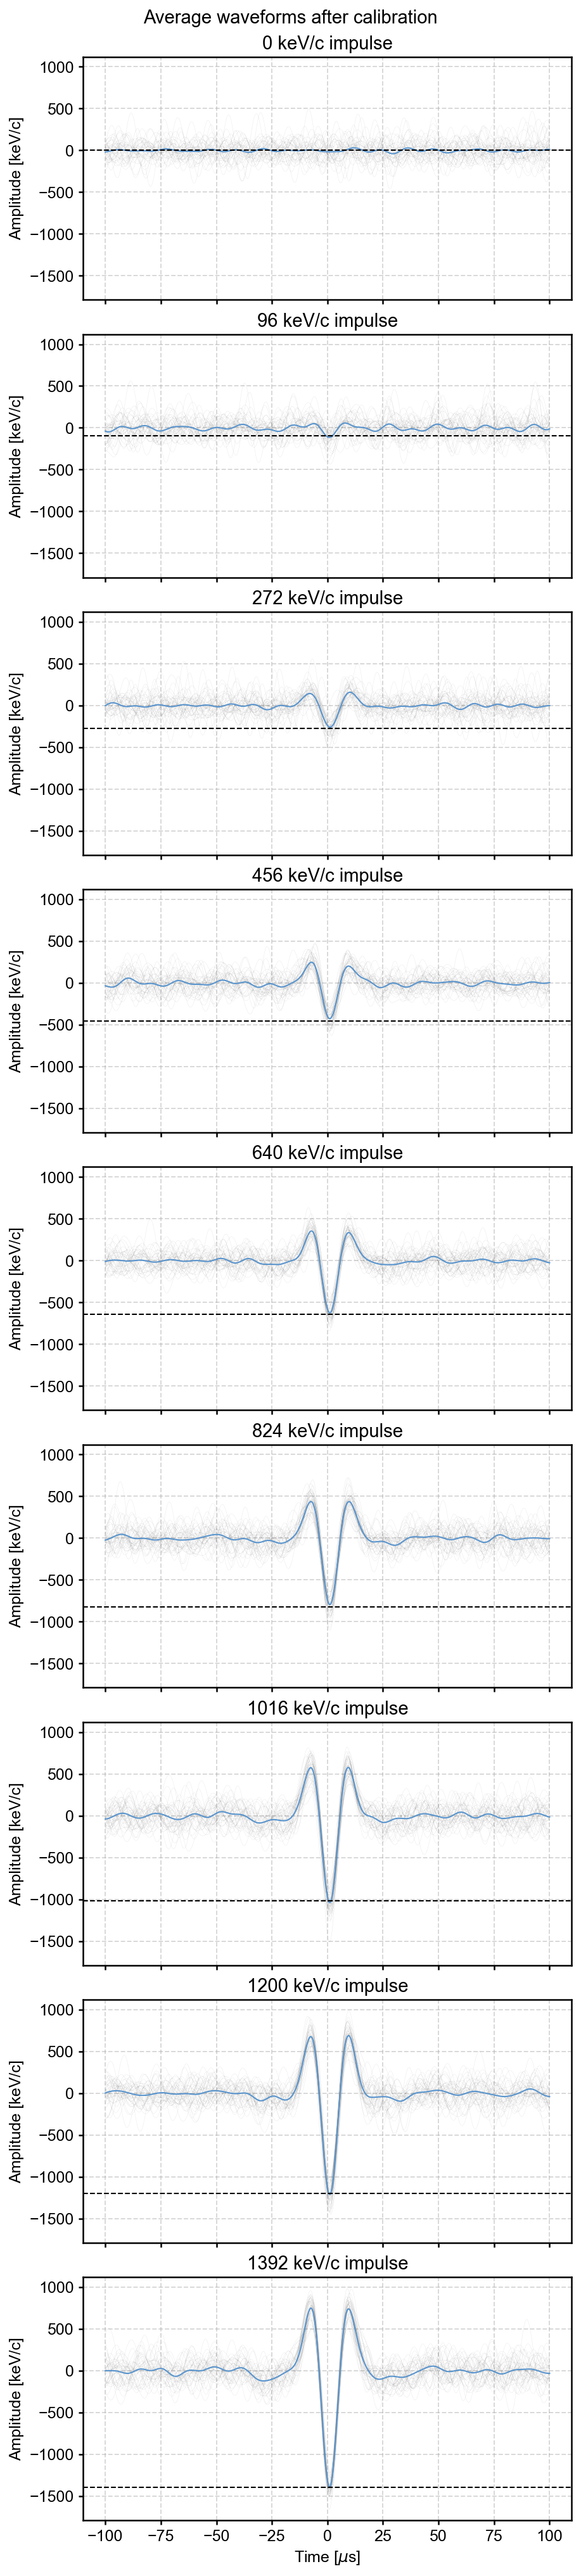

In [109]:
fig, ax = plt.subplots(mean_pulses.shape[0], figsize=(6, 3*mean_pulses.shape[0]), \
                       sharex=True, sharey=True, layout='constrained')
for i in range(mean_pulses.shape[0]):
    ax[i].plot(times*1e6, to_keV(pulses[i].T, *cal_params), lw=0.2, alpha=0.1, color='k')
    ax[i].plot(times*1e6, to_keV(mean_pulses[i], *cal_params))
    ax[i].axhline(-pulse_amps_keV[i], color='k', ls='--')
    ax[i].set_ylabel('Amplitude [keV/c]')
    ax[i].set_title('{:.0f} keV/c impulse'.format(pulse_amps_keV[i]))
    ax[i].grid(which='both')
ax[-1].set_xlabel(r'Time [$\mu$s]')
fig.suptitle('Average waveforms after calibration')


#### With $C$ from noise floor:

0 keV impulse:		 23.9 keV resolution

0 keV impulse:		 67.5 keV resolution

96 keV impulse:		 95.1 keV resolution

272 keV impulse:	 121.1 keV resolution

456 keV impulse:	 144.7 keV resolution

640 keV impulse:	 129.0 keV resolution

824 keV impulse:	 163.4 keV resolution

1016 keV impulse:	 153.7 keV resolution

1200 keV impulse:	 161.5 keV resolution

1392 keV impulse:	 206.2 keV resolution

#### With $C=2\times10^{-23}$:

0 keV impulse:		 23.4 keV resolution

0 keV impulse:		 70.2 keV resolution

96 keV impulse:		 91.4 keV resolution

272 keV impulse:	 121.0 keV resolution

456 keV impulse:	 133.2 keV resolution

640 keV impulse:	 115.7 keV resolution

824 keV impulse:	 154.4 keV resolution

1016 keV impulse:	 146.2 keV resolution

1200 keV impulse:	 131.9 keV resolution

1392 keV impulse:	 179.4 keV resolution

#### 20250911_p10e_4e-8mbar_30khz_d93khz_0 with 25 kHz $<f<$ 35 kHz

$C=0$: array([164.52130735, 170.63247831, 191.28631469, 195.13594568])

$C=10^{-23}$: array([161.33673156, 172.74397352, 189.8121316 , 195.77286286])

$C=10^{-22}$: array([158.59649287, 179.76753647, 200.01657282, 199.80805243])

$C=3\times10^{-23}$: array([158.9040047 , 175.48647758, 195.62403251, 196.81672851])

$C=2\times10^{-23}$: array([159.11806082, 172.94040413, 193.0738833 , 194.75396681])

#### 20250910_p10e_5e-8mbar_30khz_d93khz_0

$C=2\times10^{-23}$: array([282.49357429, 239.32407896, 228.48552635, 280.59351053])

$C=10^{-24}$: array([278.52707479, 235.03460465, 225.51233606, 277.68370185])

In [110]:
data_path = '/Users/clarke/Documents/Research/Nanospheres/Data/'
# base_path = '/Volumes/LaCie/gas_collisions/pulse_calibration/sphere_20250908/'
base_path = '/Users/clarke/Data/gas_collisions/background_data/sphere_20251129/' #sphere_20250908/'
# drive_path = '/Volumes/LaCie/'
drive_path = '/Users/clarke/Data/'
# base_path = '/Volumes/LaCie/pulse_calibration/sphere_20250406/'

if not os.path.exists(drive_path):
    print('Error: check that the external drive is plugged in!')

folders = glob(base_path + '*')

datasets = {}

for folder in folders:
    print(folder.split(base_path)[-1])
    all_items = glob(folder + '/*')
    subfolders = np.unique(['_'.join(s.split('_')[:-1]) for s in all_items])
    sub_datasets = []
    for subfolder in subfolders:
        sub_datasets.append(subfolder.split(base_path)[-1].split('/')[-1])
        print('\t' + subfolder.split(base_path)[-1].split('/')[-1])
    datasets[folder.split(base_path)[-1]] = sub_datasets

20251201_p8e_7e-8mbar
	20251201_df
